In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
import os

parquet_directory = "/Users/zhihaosu/Desktop/NYU/Courses/DS 1018/electricity_demand_forecasting/data"

parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith(".parquet")]

dfs = {}

for file in parquet_files:
    file_path = os.path.join(parquet_directory, file)
    dfs[file] = pd.read_parquet(file_path)

### Load and process the dataset

In [ ]:
demand = dfs["demand.parquet"]
metadata = dfs["metadata.parquet"]
weather = dfs["weather.parquet"]
# Filter metadata for the "London Smart Meter Data" dataset
london_metadata = metadata[metadata["dataset"] == "London Smart Meter Data"]

# Get the unique IDs of meters in this group
london_unique_ids = london_metadata["unique_id"].unique()

# Filter demand data for the unique IDs in the London group
london_demand = demand[demand["unique_id"].isin(london_unique_ids)]

# Remove rows with empty or null 'y' values
london_demand = london_demand.dropna(subset=["y"])

In [4]:
london_demand

unique_id           timestamp      y
0          a4077c2f0ac5f939 2012-10-12 00:30:00  0.000
1          a4077c2f0ac5f939 2012-10-12 01:00:00  0.000
2          a4077c2f0ac5f939 2012-10-12 01:30:00  0.000
3          a4077c2f0ac5f939 2012-10-12 02:00:00  0.000
4          a4077c2f0ac5f939 2012-10-12 02:30:00  0.000
...                     ...                 ...    ...
168323646  d22d7543ed4a4362 2014-02-27 22:00:00  0.173
168323647  d22d7543ed4a4362 2014-02-27 22:30:00  0.205
168323648  d22d7543ed4a4362 2014-02-27 23:00:00  0.221
168323649  d22d7543ed4a4362 2014-02-27 23:30:00  0.222
168323650  d22d7543ed4a4362 2014-02-28 00:00:00  0.183

[167709226 rows x 3 columns]

In [5]:
london_demand["date"] = london_demand["timestamp"].dt.date

daily_demand = london_demand.groupby("date")["y"].mean().reset_index()

split_date_daily = daily_demand["date"].min() + 0.8 * (
    daily_demand["date"].max() - daily_demand["date"].min()
)
split_date_daily = pd.to_datetime(split_date_daily).date()

train_data_daily = daily_demand[daily_demand["date"] < split_date_daily]
test_data_daily = daily_demand[daily_demand["date"] >= split_date_daily]

In [7]:
train_series = train_data_daily.set_index("date")["y"]
test_series = test_data_daily.set_index("date")["y"]

### Use FFT to visualize the seasonality in the data

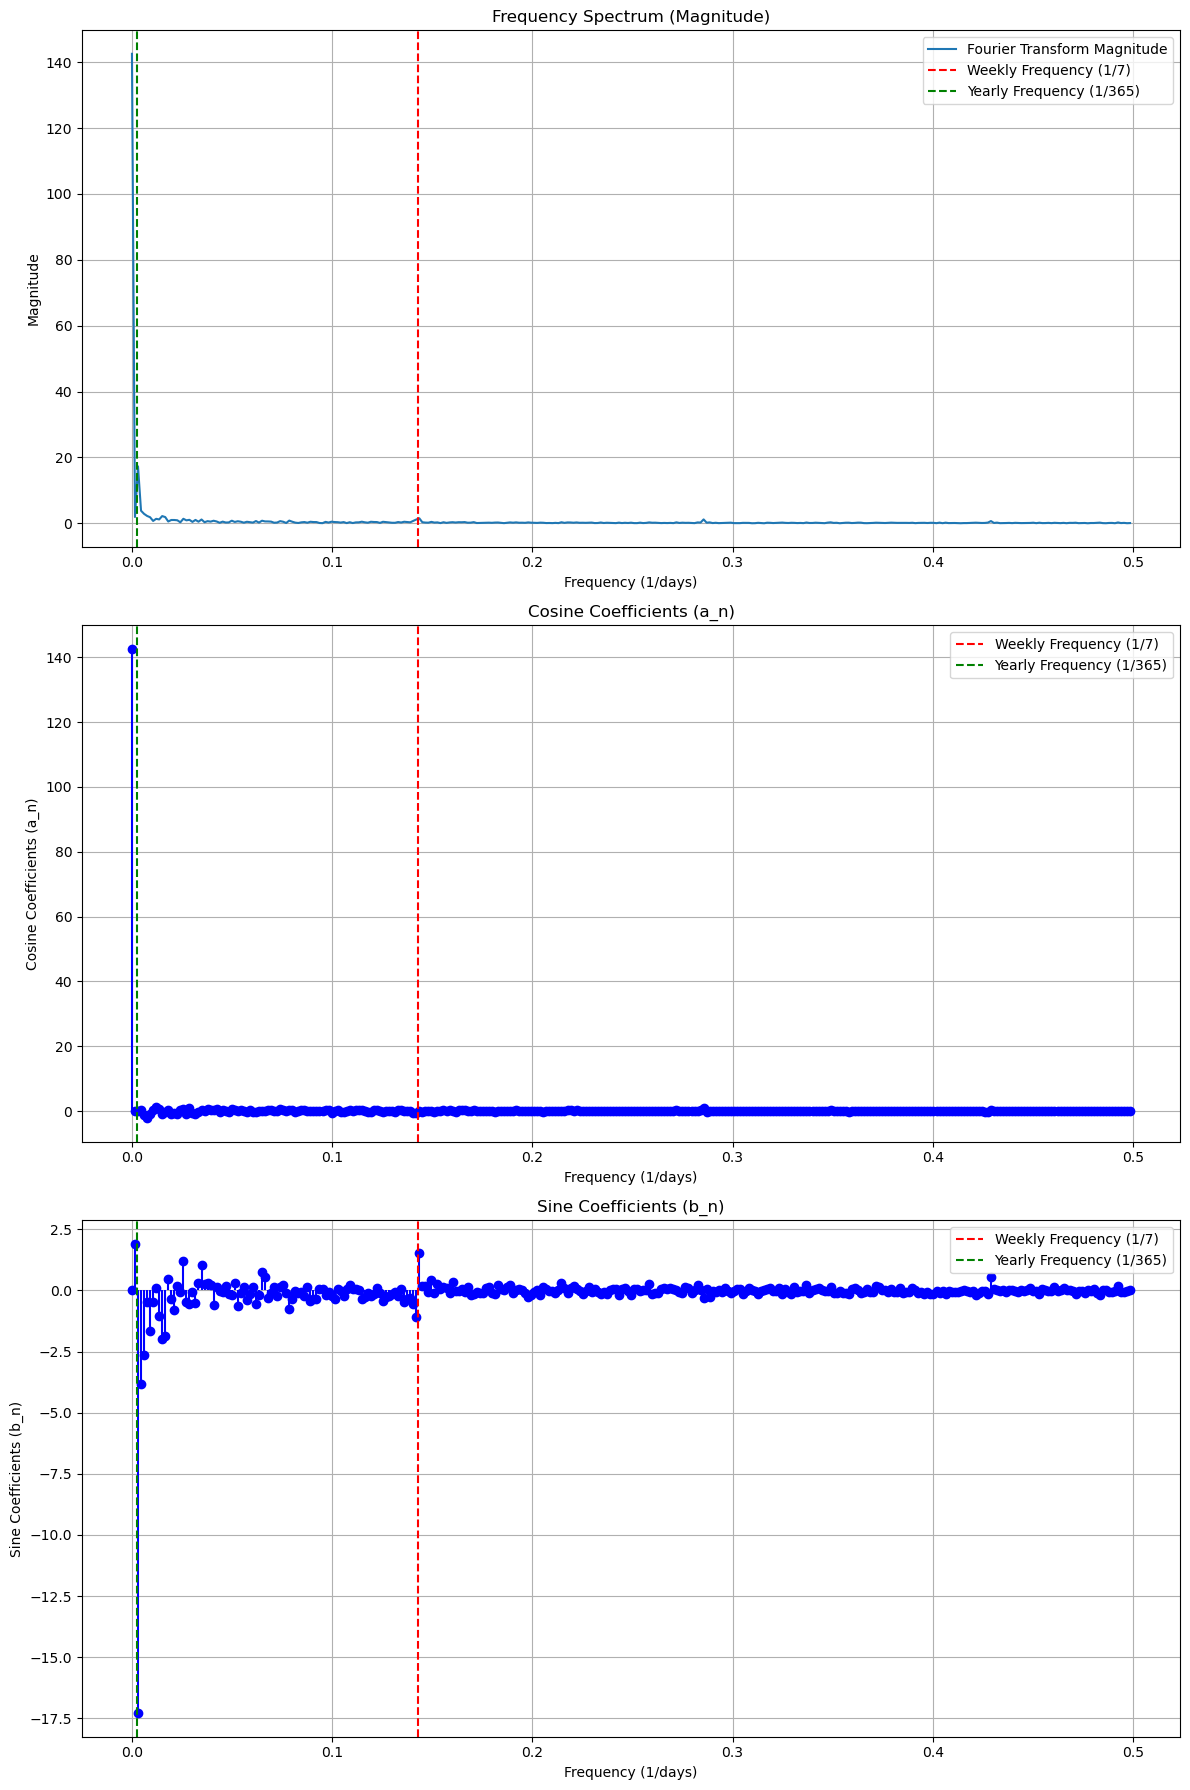

In [ ]:
train_series.index = pd.to_datetime(train_series.index)
y = np.array(train_series)

# Perform Fourier Transform
n = len(y)  # Number of samples
fft_values = np.fft.fft(y)  # Perform FFT
frequencies = np.fft.fftfreq(n, d=1)  # d=1 assumes unit time step (e.g., daily)

# Only consider the positive half of the frequencies (symmetry in FFT)
positive_frequencies = frequencies[:n // 2]
positive_fft_values = fft_values[:n // 2]

# Magnitude of FFT values
magnitude = np.abs(positive_fft_values)

# Extract cosine (a_n) and sine (b_n) coefficients
a_n = positive_fft_values.real  # Real part: cosine coefficients
b_n = positive_fft_values.imag  # Imaginary part: sine coefficients

# Highlight weekly and yearly frequencies
weekly_frequency = 1 / 7
yearly_frequency = 1 / 365

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot magnitude of FFT
axs[0].plot(positive_frequencies, magnitude, label="Fourier Transform Magnitude")
axs[0].axvline(x=weekly_frequency, color='r', linestyle='--', label="Weekly Frequency (1/7)")
axs[0].axvline(x=yearly_frequency, color='g', linestyle='--', label="Yearly Frequency (1/365)")
axs[0].set_xlabel("Frequency (1/days)")
axs[0].set_ylabel("Magnitude")
axs[0].set_title("Frequency Spectrum (Magnitude)")
axs[0].legend()
axs[0].grid()

# Plot cosine coefficients (a_n)
axs[1].stem(positive_frequencies, a_n, basefmt=" ", linefmt="b-", markerfmt="bo")
axs[1].axvline(x=weekly_frequency, color='r', linestyle='--', label="Weekly Frequency (1/7)")
axs[1].axvline(x=yearly_frequency, color='g', linestyle='--', label="Yearly Frequency (1/365)")
axs[1].set_xlabel("Frequency (1/days)")
axs[1].set_ylabel("Cosine Coefficients (a_n)")
axs[1].set_title("Cosine Coefficients (a_n)")
axs[1].legend()
axs[1].grid()

# Plot sine coefficients (b_n)
axs[2].stem(positive_frequencies, b_n, basefmt=" ", linefmt="b-", markerfmt="bo")
axs[2].axvline(x=weekly_frequency, color='r', linestyle='--', label="Weekly Frequency (1/7)")
axs[2].axvline(x=yearly_frequency, color='g', linestyle='--', label="Yearly Frequency (1/365)")
axs[2].set_xlabel("Frequency (1/days)")
axs[2].set_ylabel("Sine Coefficients (b_n)")
axs[2].set_title("Sine Coefficients (b_n)")
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()


### Extract features from the weather dataset

In [9]:
from sklearn.preprocessing import StandardScaler

weather['date'] = pd.to_datetime(weather['timestamp']).dt.date  
weather = weather.set_index('date')  

weather = weather[['temperature_2m','soil_temperature_7_to_28cm']]  

weather.index = pd.to_datetime(weather.index)  
weather_data = weather.resample('D').mean().fillna(method='ffill') 

weather_train = weather_data.loc[train_data_daily['date'].min():train_data_daily['date'].max()]
weather_test = weather_data.loc[test_data_daily['date'].min():test_data_daily['date'].max()]

scaler = StandardScaler()
weather_train_scaled = scaler.fit_transform(weather_train)
weather_test_scaled = scaler.transform(weather_test)

/var/folders/73/m423qw2s07g_xcdt0pnz00000000gn/T/ipykernel_55118/1312333395.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data = weather.resample('D').mean().fillna(method='ffill')


### Model the demand with Guassian Process Regression

In [76]:
import GPy
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [90]:
# Helper functions for gp qq plot visualization and analysis
def calculate_aic(log_likelihood, num_params):
    """
    Calculate Akaike Information Criterion (AIC).

    Args:
        log_likelihood (float): Log-likelihood of the model
        num_params (int): Number of parameters in the model

    Returns:
        float: AIC value
    """
    return 2 * num_params - 2 * log_likelihood

def calculate_calibration_error(y_true, y_pred, y_std, confidence_level=0.95):
    """
    Calculate calibration error for model uncertainty.

    Args:
        y_true (np.ndarray): True observed values
        y_pred (np.ndarray): Predicted mean values
        y_std (np.ndarray): Predicted standard deviation
        confidence_level (float): Confidence level to check

    Returns:
        dict: Calibration error metrics
    """
    # Calculate z-score for the specified confidence level
    z_score = stats.norm.ppf((1 + confidence_level) / 2)

    # Calculate lower and upper bounds of the confidence interval
    lower_bound = y_pred - z_score * y_std
    upper_bound = y_pred + z_score * y_std

    # Check which points are within the confidence interval
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)

    # Calculate calibration metrics
    actual_coverage = np.mean(within_interval)
    expected_coverage = confidence_level
    calibration_error = np.abs(actual_coverage - expected_coverage)

    return {
        "actual_coverage": actual_coverage,
        "expected_coverage": expected_coverage,
        "calibration_error": calibration_error,
        "under_coverage": actual_coverage < expected_coverage,
        "over_coverage": actual_coverage > expected_coverage,
    }


def create_qq_plot(y_true, y_pred, y_std, title):
    """
    Create Q-Q plot for residuals.
    """
    plt.figure(figsize=(10, 5))
    residuals = y_true.flatten() - y_pred.flatten()

    # Standardize residuals
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    # Theoretical quantiles
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))

    # Sort the residuals
    sorted_indices = np.argsort(standardized_residuals)

    plt.scatter(
        theoretical_quantiles,
        np.sort(standardized_residuals),
        color="blue",
        alpha=0.7,
        label="Residuals",
    )
    plt.plot(
        theoretical_quantiles,
        theoretical_quantiles,
        color="red",
        linestyle="--",
        label="Ideal Normal Distribution",
    )
    plt.title(f"Q-Q Plot of Residuals: {title}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Sample Quantiles")
    plt.legend()
    plt.show()

In [110]:
# Main function used for experiment
def run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    weather_train_scaled=None,
    weather_test_scaled=None,
    training_title=None,
    test_title=None,
    confidence_level=0.95,
    optimize_restarts=True,
    num_restarts=5,
):
    """
    Run Gaussian Process Regression with kernel, optional weather data, and uncertainty calibration.

    Args:
        train_series (pd.Series): Training time series data.
        test_series (pd.Series): Test time series data.
        kernel (GPy.kern.Kern): The kernel to use for GP regression.
        weather_train_scaled (np.ndarray, optional): Scaled weather data for training.
        weather_test_scaled (np.ndarray, optional): Scaled weather data for testing.
        training_title (str, optional): Custom title for training plot.
        test_title (str, optional): Custom title for test plot.
        confidence_level (float, optional): Confidence level for interval (default 0.95).
        num_restarts (int): Number of restarts for the optimizer (default 5).

    Returns:
        dict: Comprehensive results including model, predictions, and calibration metrics.
    """
    np.random.seed(42)

    # Prepare time-based feature (days since start)
    train_series.index = pd.to_datetime(train_series.index)
    time_since_start = (
        train_series.index - train_series.index.min()
    ).days.values.reshape(-1, 1)

    # Combine time feature with weather data if provided
    if weather_train_scaled is not None:
        X_train = np.hstack([time_since_start, weather_train_scaled])
    else:
        X_train = time_since_start

    y_train = np.array(train_series).reshape(-1, 1)

    # Normalize the target variable (y)
    y_mean = y_train.mean()
    y_std_orig = y_train.std()
    y_normalized = (y_train - y_mean) / y_std_orig

    # Train GP model
    model = GPy.models.GPRegression(X_train, y_normalized, kernel)
    if optimize_restarts:
        model.optimize_restarts(num_restarts=num_restarts, verbose=True, messages=True, max_iters=500)
    else:
        model.optimize()

    # Predict on training data
    y_pred_train, y_var_train = model.predict(X_train)
    y_pred_train_orig = y_pred_train * y_std_orig + y_mean  # De-normalize predictions
    y_std_train = np.sqrt(y_var_train) * y_std_orig  # De-normalize uncertainty

    # Calculate training metrics
    mse_train = mean_squared_error(y_train, y_pred_train_orig)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train_orig)
    log_likelihood_train = model.log_likelihood()
    # Calculate AIC for training
    num_params_train = len(model.param_array)
    aic_train = calculate_aic(log_likelihood_train, num_params_train)

    # Calculate training calibration
    train_calibration = calculate_calibration_error(
        y_train, y_pred_train_orig, y_std_train, confidence_level
    )

    print(f"Training Results:")
    print(f"Mean Squared Error (MSE): {mse_train:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_train:.2%}")
    print(f"Log Likelihood: {log_likelihood_train}")
    print(f"AIC: {aic_train:.4f}")
    print("\nTraining Calibration Metrics:")
    for key, value in train_calibration.items():
        print(f"{key}: {value}")

    # Plot training predictions
    plt.figure(figsize=(10, 5))
    plt.plot(
        train_series.index,
        y_pred_train_orig,
        color="#8A2BE2",
        label="GP Posterior Distribution",
    )
    plt.plot(
        train_series.index, y_train, "x", color="k", label="Observed Data", markersize=7
    )
    plt.fill_between(
        train_series.index,
        (y_pred_train_orig - 2 * y_std_train).flatten(),
        (y_pred_train_orig + 2 * y_std_train).flatten(),
        color="#99d8c9",
        alpha=0.5,
        label="95% Confidence Interval",
    )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption")
    plt.title(training_title or "GP Regression: Training Data")
    plt.show()

    # Create Q-Q plot for training residuals
    create_qq_plot(
        y_train, y_pred_train_orig, y_std_train, "Training Q-Q Plot"
    )

    # Prepare test data
    test_series.index = pd.to_datetime(test_series.index)
    time_since_start_test = (
        test_series.index - train_series.index.min()
    ).days.values.reshape(-1, 1)

    if weather_test_scaled is not None:
        X_test = np.hstack([time_since_start_test, weather_test_scaled])
    else:
        X_test = time_since_start_test

    y_test = np.array(test_series).reshape(-1, 1)

    # Predict on testing data
    y_pred_test, y_var_test = model.predict(X_test)
    y_pred_test_orig = y_pred_test * y_std_orig + y_mean  # De-normalize predictions
    y_std_test = np.sqrt(y_var_test) * y_std_orig  # De-normalize uncertainty

    # Calculate testing metrics
    mse_test = mean_squared_error(y_test, y_pred_test_orig)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test_orig)
    log_likelihood_test = model.log_likelihood()

    # Calculate test calibration
    test_calibration = calculate_calibration_error(
        y_test, y_pred_test_orig, y_std_test, confidence_level
    )
    create_qq_plot(y_test, y_pred_test_orig, y_std_test, "Test Q-Q Plot")

    print(f"\nTesting Results:")
    print(f"Mean Squared Error (MSE): {mse_test:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2%}")
    print(f"Log Likelihood: {log_likelihood_test}")
    print("\nTest Calibration Metrics:")
    for key, value in test_calibration.items():
        print(f"{key}: {value}")

    # Plot testing predictions
    plt.figure(figsize=(10, 5))
    plt.plot(
        test_series.index, y_pred_test_orig, color="#8A2BE2", label="GP Posterior Mean"
    )
    plt.plot(
        test_series.index,
        y_test,
        "x",
        color="k",
        label="Test Observed Data",
        markersize=7,
    )
    plt.fill_between(
        test_series.index,
        (y_pred_test_orig - 2 * y_std_test).flatten(),
        (y_pred_test_orig + 2 * y_std_test).flatten(),
        color="#99d8c9",
        alpha=0.5,
        label="95% Confidence Interval",
    )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption")
    plt.title(test_title or "GP Regression: Test Data")
    plt.show()

    # Return comprehensive results
    return {
        "model": model,
        "training_predictions": y_pred_train_orig,
        "test_predictions": y_pred_test_orig,
        "training_calibration": train_calibration,
        "test_calibration": test_calibration,
        "training_metrics": {
            "mse": mse_train,
            "mape": mape_train,
            "log_likelihood": log_likelihood_train,
        },
        "test_metrics": {
            "mse": mse_test,
            "mape": mape_test,
            "log_likelihood": log_likelihood_test,
        },
    }

Training Results:
Mean Squared Error (MSE): 0.0013
Mean Absolute Percentage Error (MAPE): 14.65%
Log Likelihood: -893.914143728098
AIC: 1795.8283

Training Calibration Metrics:
actual_coverage: 0.9818731117824774
expected_coverage: 0.95
calibration_error: 0.031873111782477426
under_coverage: False
over_coverage: True


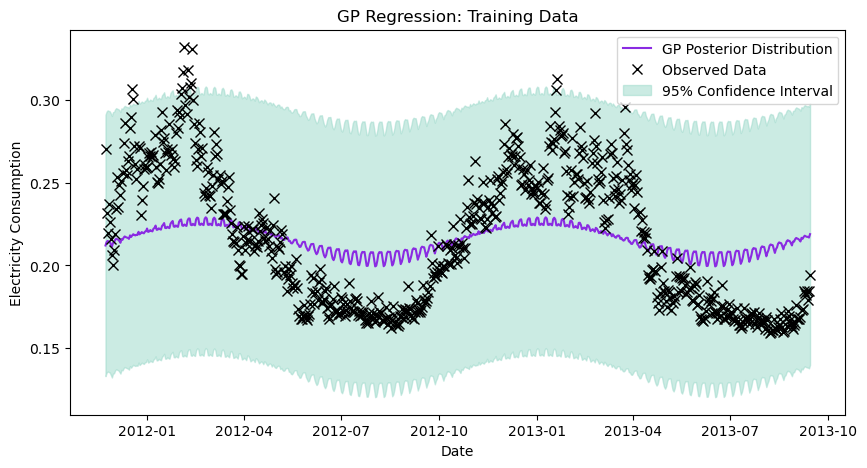

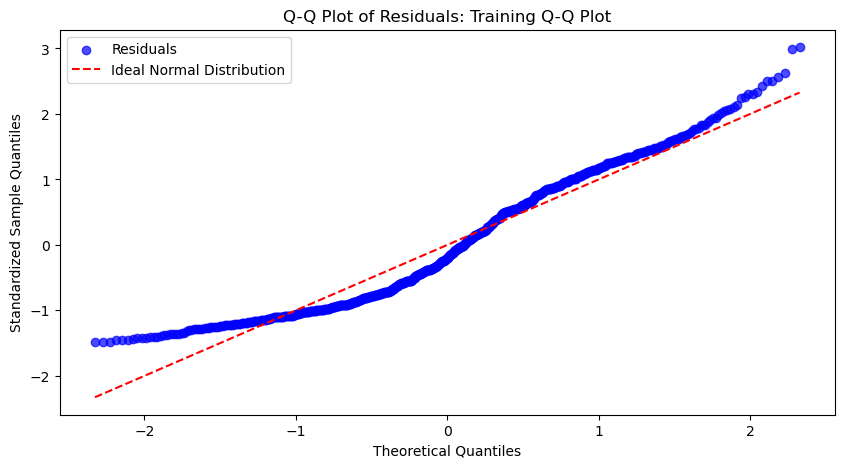

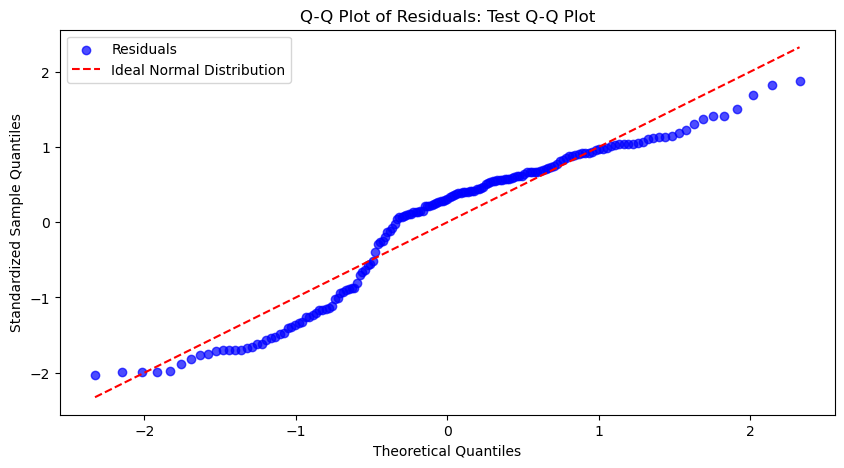


Testing Results:
Mean Squared Error (MSE): 0.0005
Mean Absolute Percentage Error (MAPE): 9.42%
Log Likelihood: -893.914143728098

Test Calibration Metrics:
actual_coverage: 1.0
expected_coverage: 0.95
calibration_error: 0.050000000000000044
under_coverage: False
over_coverage: True


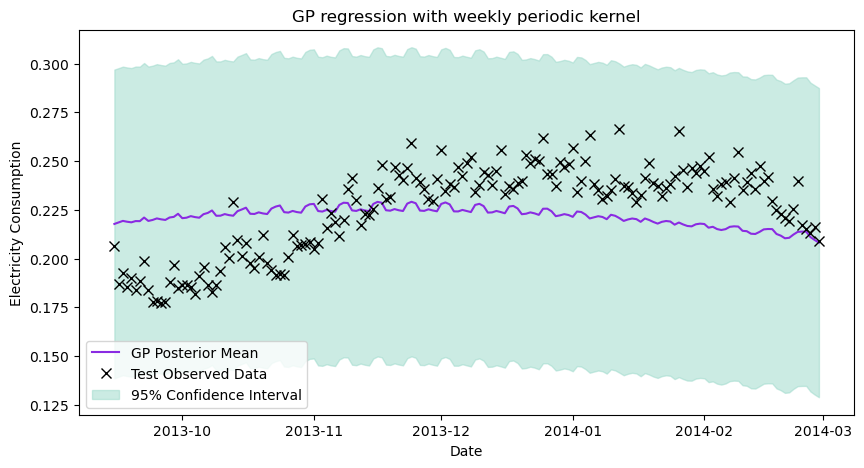

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s41  006   8.920515e+02   3.497832e+07 
    13s63  024   7.502981e+02   1.301526e+05 
    28s32  050   3.480848e+02   5.102915e+03 
    30s76  054   3.480760e+02   2.908505e-03 
Runtime:     30s76
Optimization status: Converged

Optimization restart 1/5, f = 348.0759906702958
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s37  006   9.396633e+02   3.089111e+04 
    12s51  022   9.392772e+02   5.275256e+06 
    15s32  027   9.392202e+02   2.231885e-02 
Runtime:     15s32
Optimization status: Converged

Optimization restart 2/5, f = 939.2202073563514
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s00  000   9.483989e+02   2.231885e-02 
    02s55  004   9.468837e+02   1.163581e+04 
    06s31  011   8.693543e+02   8.239492e+10 
Runtime:     06s31
Optimization status: Converged

Optimization resta

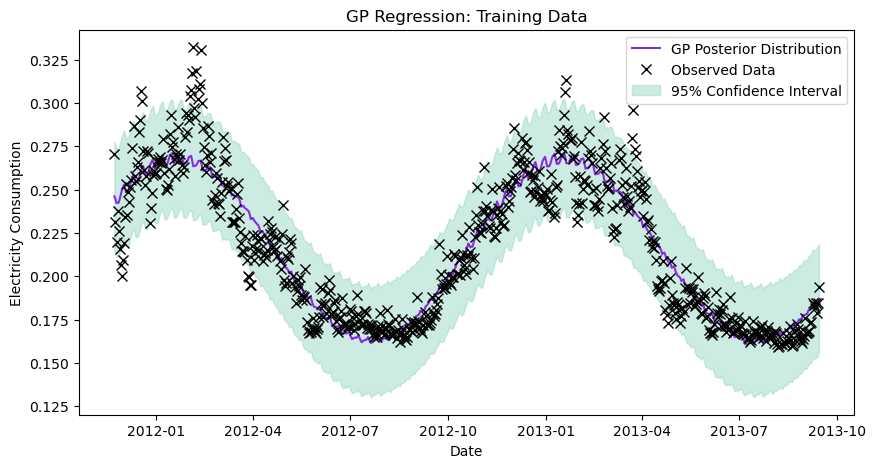

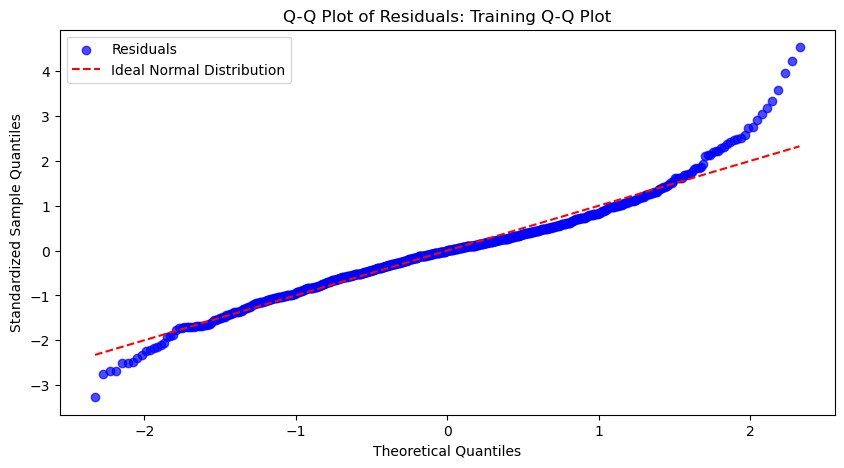

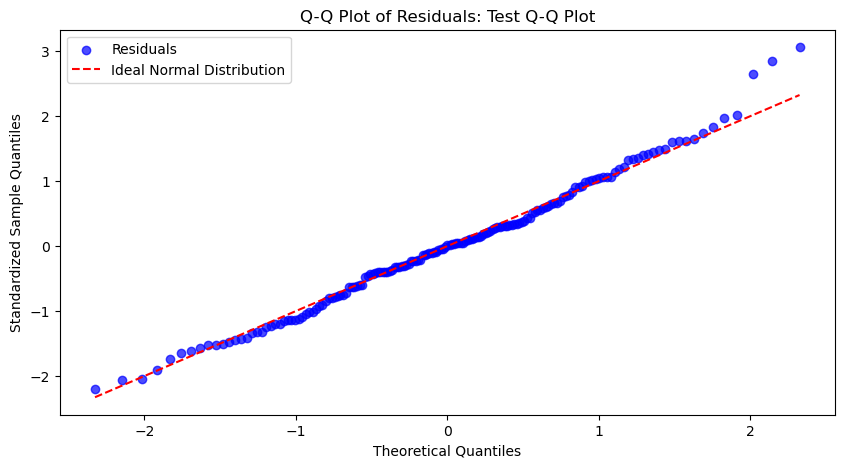


Testing Results:
Mean Squared Error (MSE): 0.0005
Mean Absolute Percentage Error (MAPE): 8.39%
Log Likelihood: -348.0759906702958

Test Calibration Metrics:
actual_coverage: 0.8323353293413174
expected_coverage: 0.95
calibration_error: 0.11766467065868258
under_coverage: True
over_coverage: False


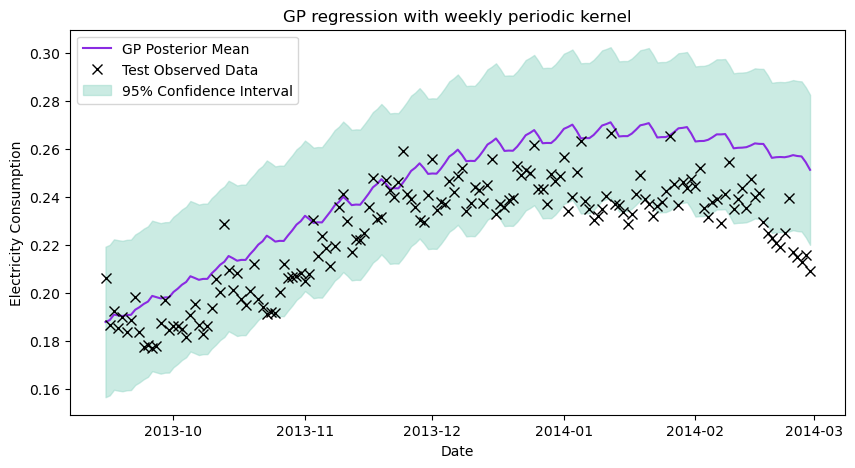

Training Results:
Mean Squared Error (MSE): 0.0002
Mean Absolute Percentage Error (MAPE): 4.83%
Log Likelihood: -316.5948871711696
AIC: 641.1898

Training Calibration Metrics:
actual_coverage: 0.9380664652567976
expected_coverage: 0.95
calibration_error: 0.011933534743202356
under_coverage: True
over_coverage: False


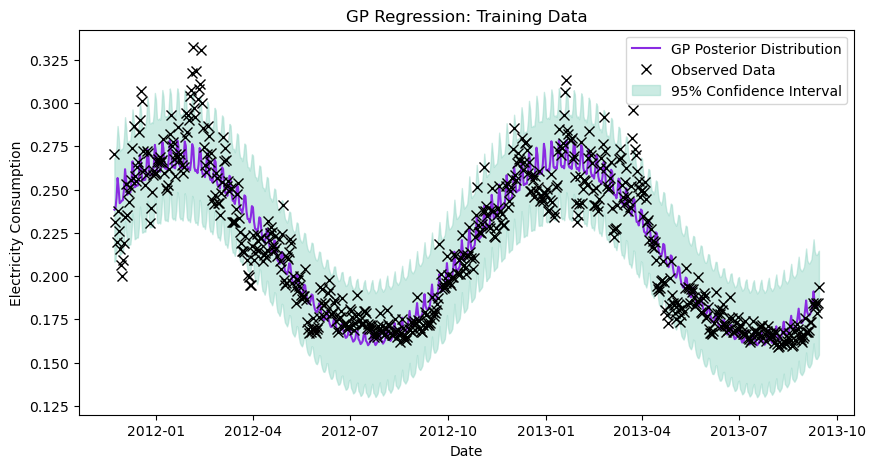

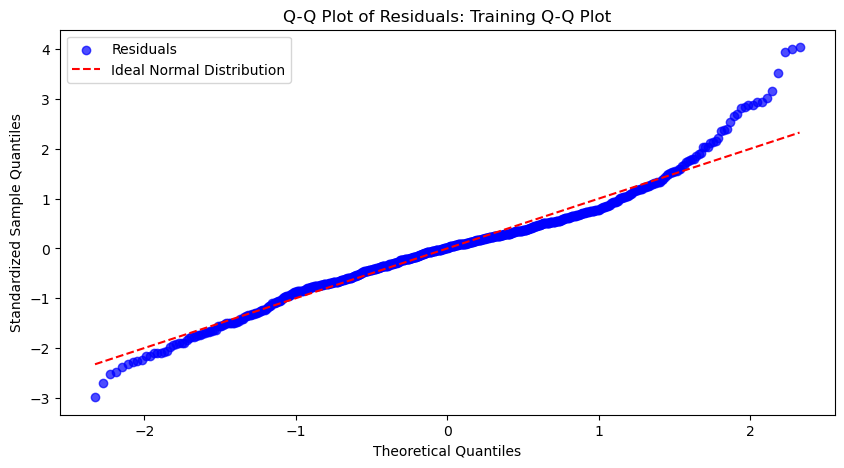

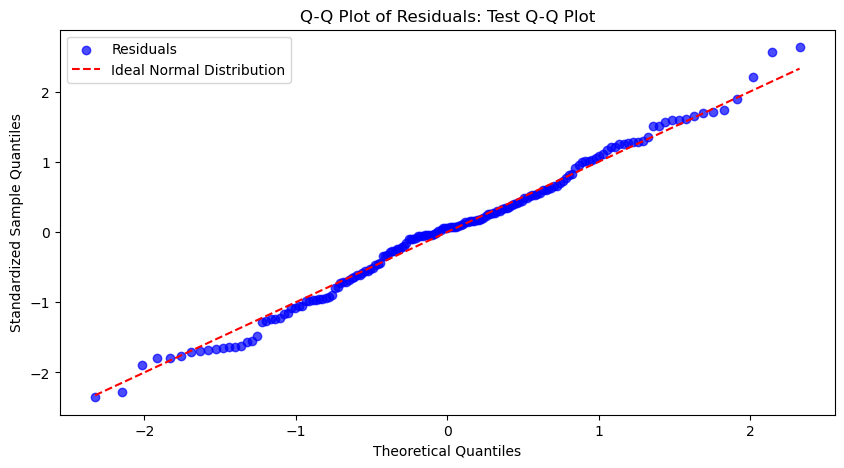


Testing Results:
Mean Squared Error (MSE): 0.0005
Mean Absolute Percentage Error (MAPE): 8.42%
Log Likelihood: -316.5948871711696

Test Calibration Metrics:
actual_coverage: 0.7844311377245509
expected_coverage: 0.95
calibration_error: 0.1655688622754491
under_coverage: True
over_coverage: False


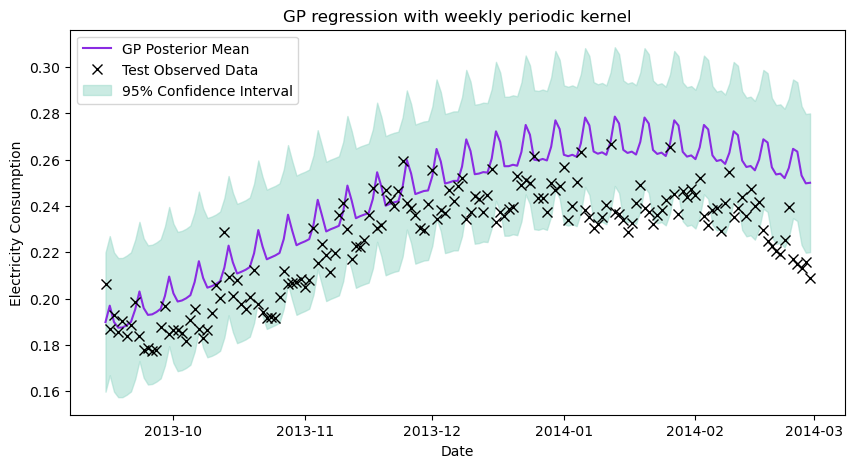

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s48  006   7.005136e+02   4.464783e+04 
    13s91  024   3.165949e+02   1.394824e-04 
Runtime:     13s91
Optimization status: Converged

Optimization restart 1/5, f = 316.59488842785106
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s48  006   9.551575e+02   4.914839e+04 
    11s52  020   9.399235e+02   2.844161e+06 
    12s76  022   9.397389e+02   1.641465e+01 
    27s15  044   9.393375e+02   1.727721e-01 
    30s41  048   9.393374e+02   8.512245e-03 
    33s67  053   9.393373e+02   1.736430e-05 
Runtime:     33s67
Optimization status: Converged

Optimization restart 2/5, f = 939.3373102999824
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    06s91  012   9.421813e+02   8.341962e+01 
    21s57  038   9.393374e+02   5.296872e-05 
    24s98  044   9.393373e+02   6.712386e-05 
    26s80  047   9.393

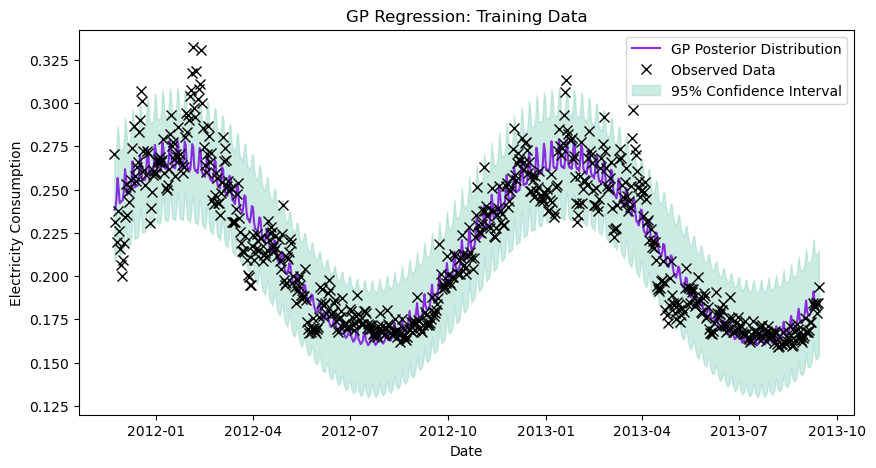

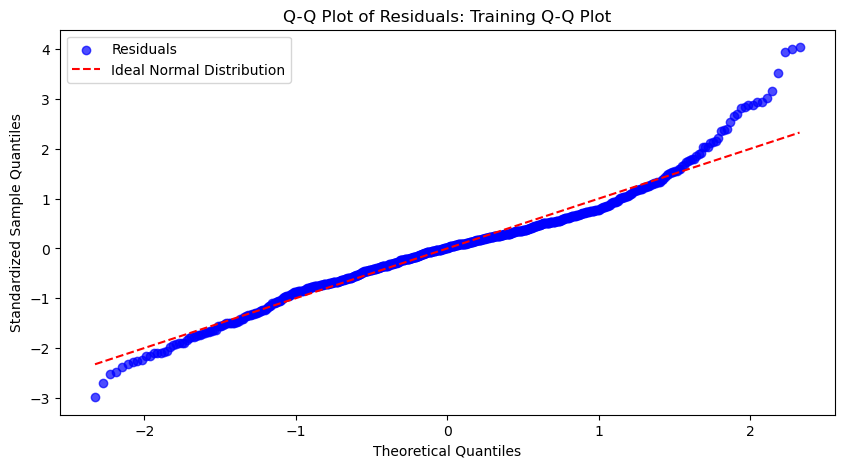

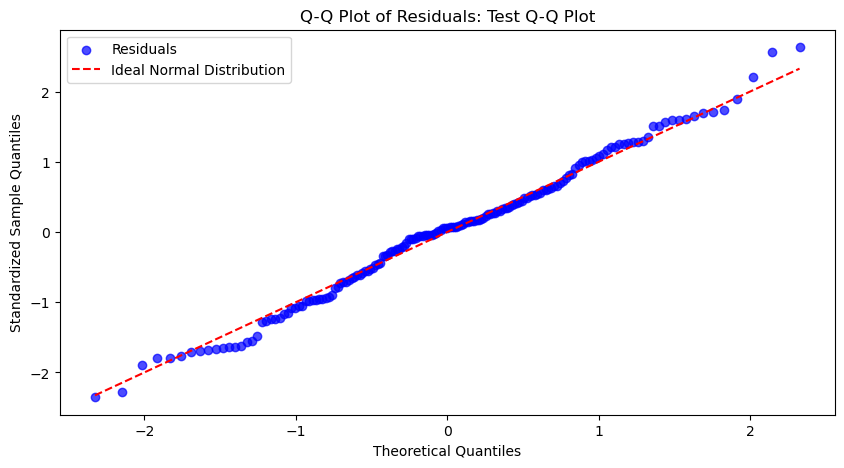


Testing Results:
Mean Squared Error (MSE): 0.0005
Mean Absolute Percentage Error (MAPE): 8.42%
Log Likelihood: -316.59488842785106

Test Calibration Metrics:
actual_coverage: 0.7844311377245509
expected_coverage: 0.95
calibration_error: 0.1655688622754491
under_coverage: True
over_coverage: False


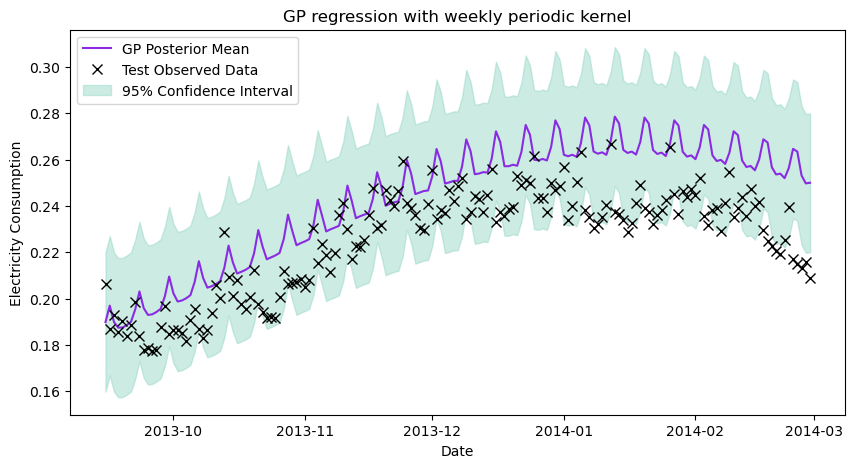

In [112]:
# Define kernel (e.g., RBF + Periodic, periodic only in this example)
k_periodic_1 = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=10, period=7
)
k_periodic_2 = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=20, period=7
)

# Run GP regression
results_periodic_1 = run_gp_with_kernel(
    train_series,
    test_series,
    k_periodic_1,
    test_title="GP regression with weekly periodic kernel",
    optimize_restarts=False
)
results_periodic_1_restart = run_gp_with_kernel(
    train_series,
    test_series,
    k_periodic_1,
    test_title="GP regression with weekly periodic kernel",
)
results_periodic_2 = run_gp_with_kernel(
    train_series,
    test_series,
    k_periodic_2,
    test_title="GP regression with weekly periodic kernel",
    optimize_restarts=False,
)
results_periodic_2_restart = run_gp_with_kernel(
    train_series,
    test_series,
    k_periodic_2,
    test_title="GP regression with weekly periodic kernel",
)

Training Results:
Mean Squared Error (MSE): 0.0001
Mean Absolute Percentage Error (MAPE): 3.04%
Log Likelihood: -104.64867200332355
AIC: 215.2973

Training Calibration Metrics:
actual_coverage: 0.9516616314199395
expected_coverage: 0.95
calibration_error: 0.0016616314199395799
under_coverage: False
over_coverage: True


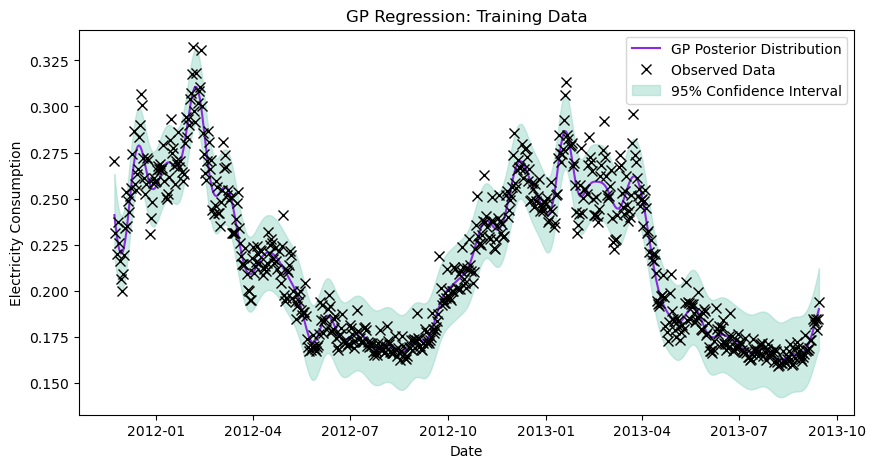

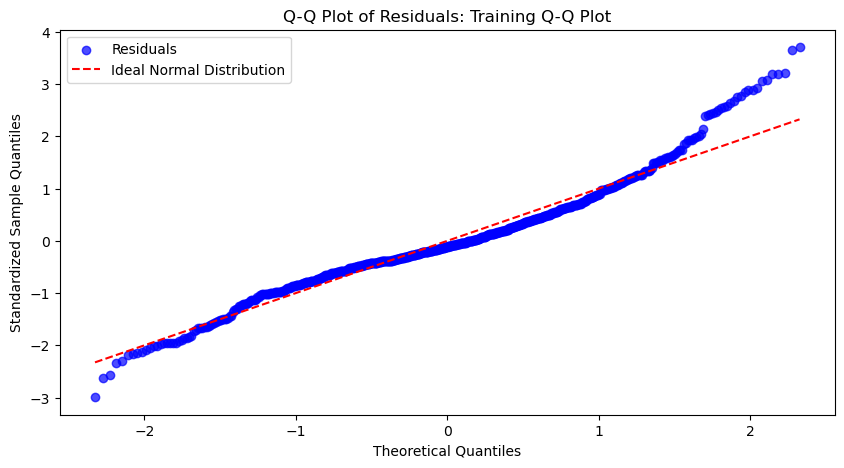

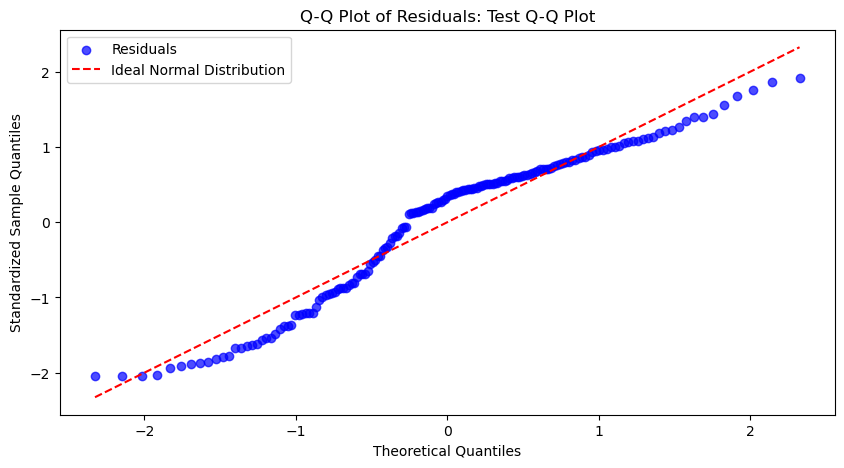


Testing Results:
Mean Squared Error (MSE): 0.0006
Mean Absolute Percentage Error (MAPE): 9.29%
Log Likelihood: -104.64867200332355

Test Calibration Metrics:
actual_coverage: 1.0
expected_coverage: 0.95
calibration_error: 0.050000000000000044
under_coverage: False
over_coverage: True


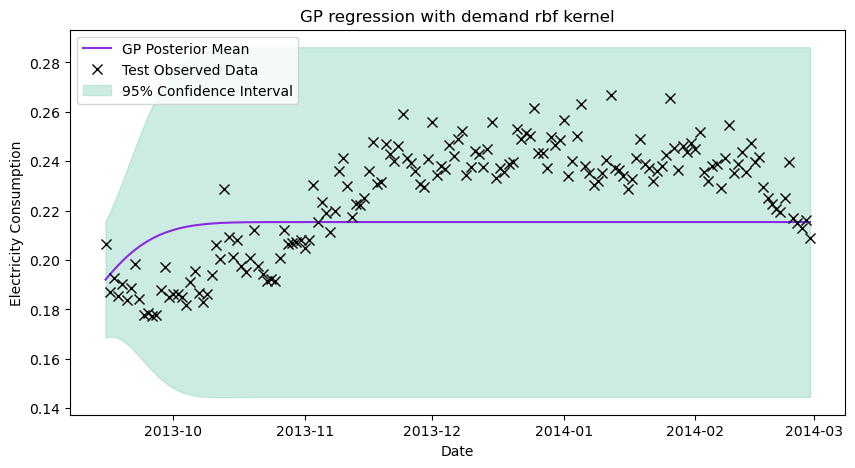

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s17  003   7.340801e+02   1.127568e+06 
    00s85  022   1.046487e+02   2.129183e-06 
Runtime:     00s85
Optimization status: Converged

Optimization restart 1/5, f = 104.64867200751013
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s19  005   1.108285e+02   2.794910e+03 
    00s53  016   9.391425e+01   2.201695e-12 
Runtime:     00s53
Optimization status: Converged

Optimization restart 2/5, f = 93.91424683011599
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s10  004   5.554112e+02   3.853028e+04 
    00s15  005   3.787931e+02   2.473634e+05 
    01s08  035   1.024129e+02   3.986736e-08 
Runtime:     01s08
Optimization status: Converged

Optimization restart 3/5, f = 102.41291493024733
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s11  002 

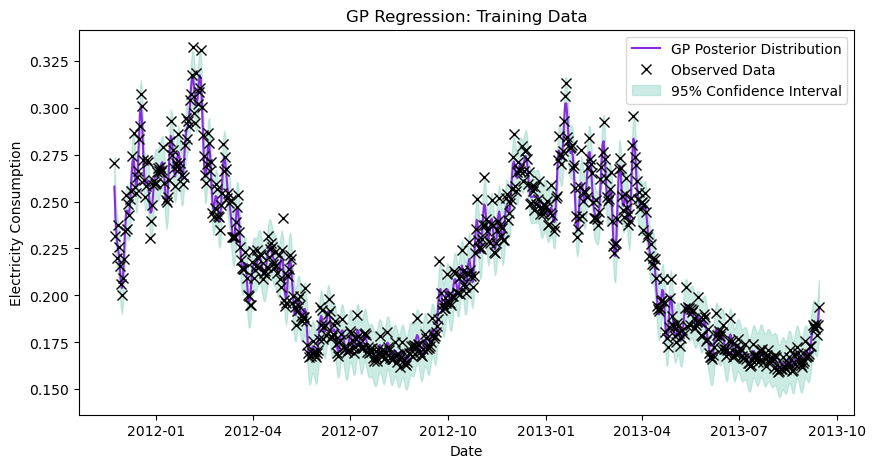

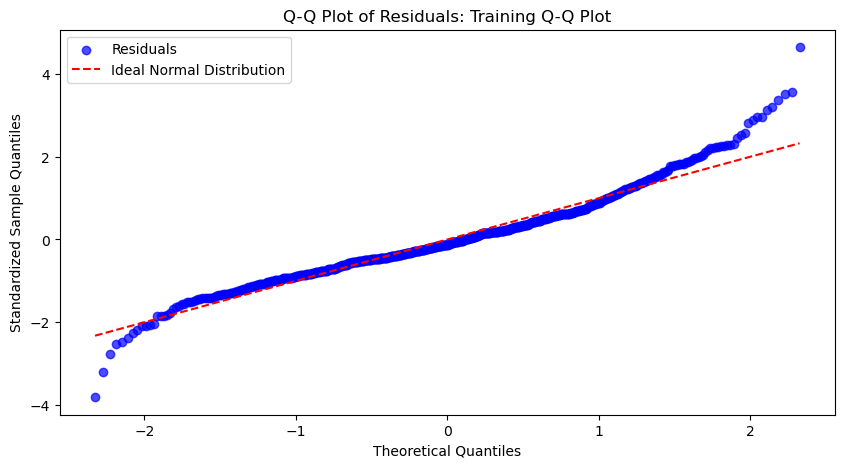

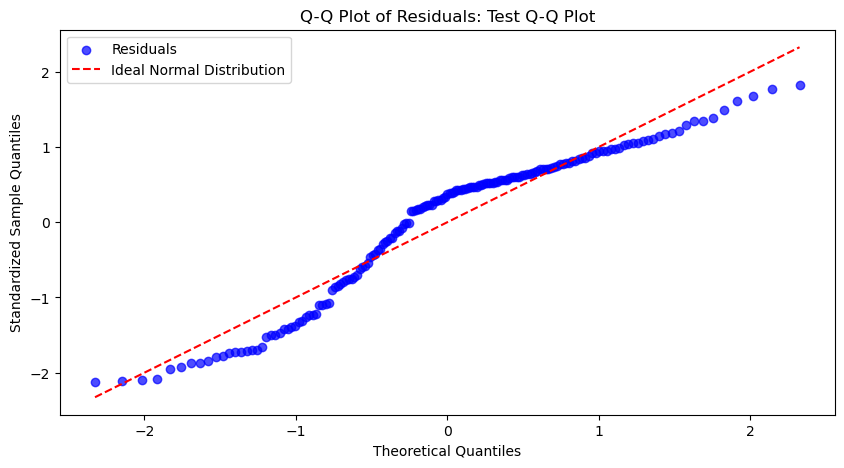


Testing Results:
Mean Squared Error (MSE): 0.0006
Mean Absolute Percentage Error (MAPE): 9.86%
Log Likelihood: -93.91424683011599

Test Calibration Metrics:
actual_coverage: 1.0
expected_coverage: 0.95
calibration_error: 0.050000000000000044
under_coverage: False
over_coverage: True


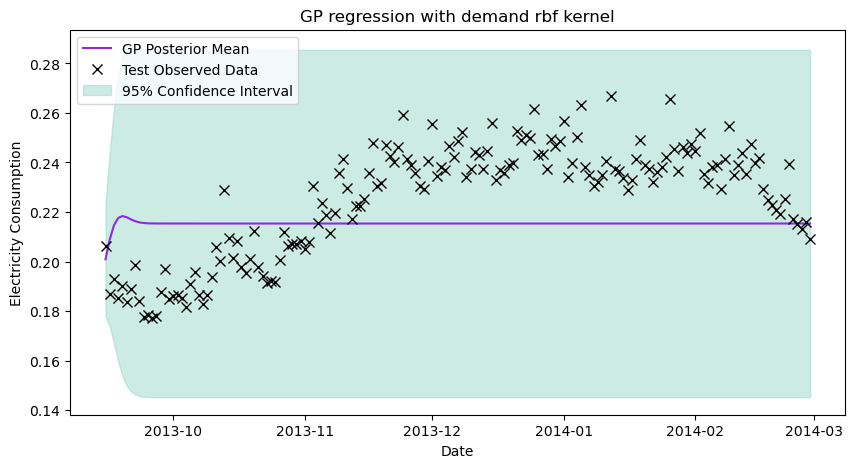

In [113]:
# GP regression with demand rbf kernel
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=20)

# Run GP regression
results_demand_rbf = run_gp_with_kernel(
    train_series,
    test_series,
    k_rbf,
    test_title="GP regression with demand rbf kernel",
    optimize_restarts=False,
)
results_demand_rbf_restart = run_gp_with_kernel(
    train_series,
    test_series,
    k_rbf,
    test_title="GP regression with demand rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    02s83  004   1.504229e+02   2.147907e+04 
    11s08  016   1.258328e+02   1.582514e+06 
    35s50  050   1.047211e+02   8.216866e+00 
    48s06  068   1.045867e+02   3.542694e-04 
    50s24  071   1.045867e+02   1.777699e-05 
Runtime:     50s24
Optimization status: Converged

Optimization restart 1/5, f = 104.586671078714
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s00  000   1.028824e+03   1.777699e-05 
    05s64  008   9.760575e+02   1.832621e+05 
    18s56  026   9.424811e+02   1.307609e+06 
    24s05  034   9.408184e+02   1.947160e+05 
 01m09s86  098   1.029401e+02   1.467247e+04 
 01m11s86  101   1.029400e+02   2.439105e-01 
Runtime:  01m11s86
Optimization status: Converged

Optimization restart 2/5, f = 102.93996970220917
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s00  000   9.7955

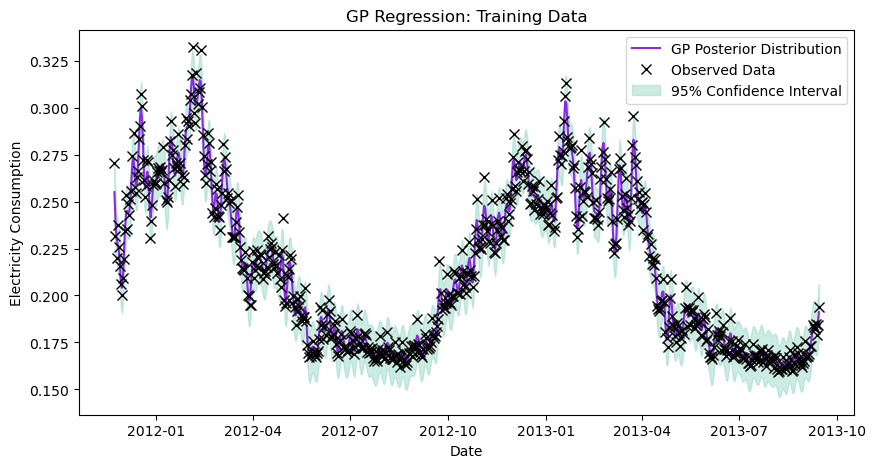

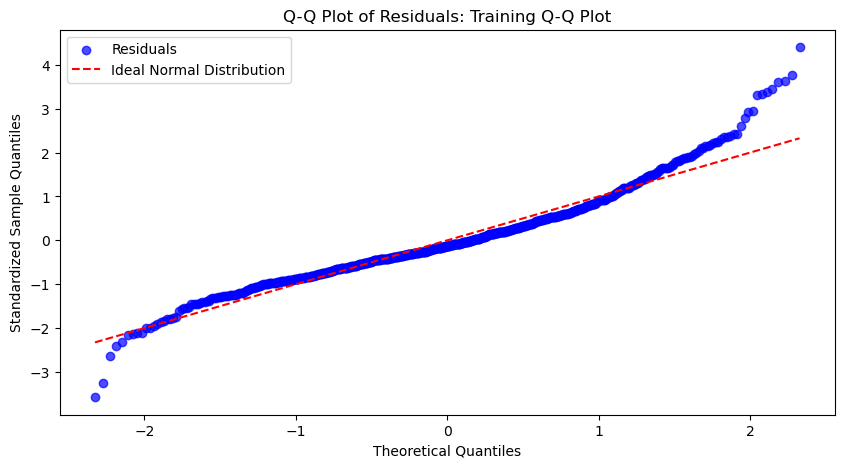

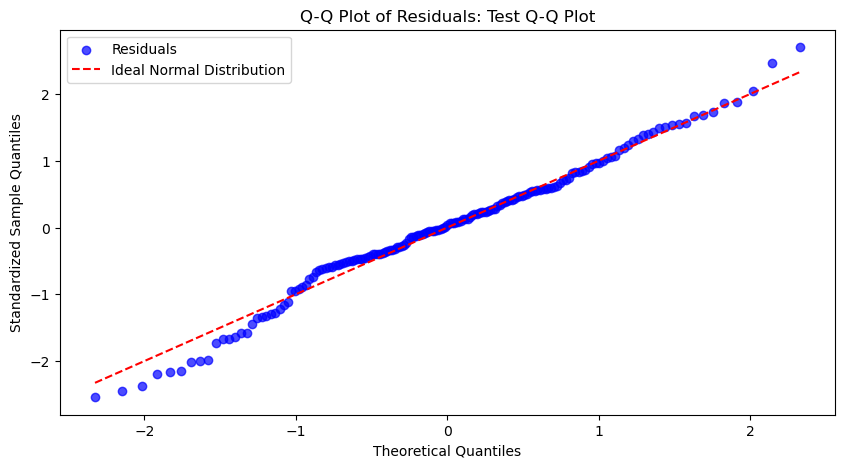


Testing Results:
Mean Squared Error (MSE): 0.0006
Mean Absolute Percentage Error (MAPE): 9.90%
Log Likelihood: 25.023787541590764

Test Calibration Metrics:
actual_coverage: 0.7904191616766467
expected_coverage: 0.95
calibration_error: 0.15958083832335324
under_coverage: True
over_coverage: False


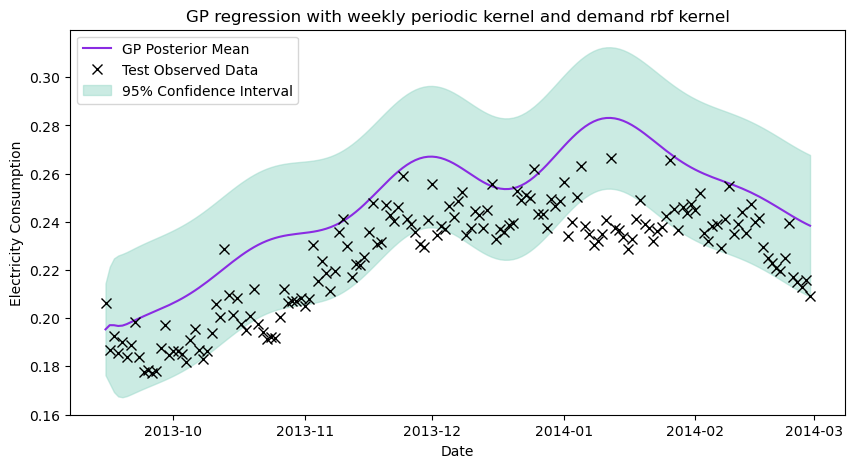

In [98]:
# Define kernel (e.g., RBF + Periodic)
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10)
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=10, period=7
)
kernel = k_rbf + k_periodic

# Run GP regression
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    test_title="GP regression with weekly periodic kernel and demand rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    04s40  006   3.933013e+02   4.185944e+08 
    16s66  023   1.536584e+02   2.099777e+02 
    44s12  063   1.038209e+02   4.609425e-01 
    49s15  070   1.038208e+02   2.933540e-06 
Runtime:     49s15
Optimization status: Converged

Optimization restart 1/5, f = 103.82081023092746
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    07s06  010   9.400525e+02   4.504537e+06 
    11s22  017   9.381962e+02   1.007509e+10 
Runtime:     11s22
Optimization status: Converged

Optimization restart 2/5, f = 938.1962387870934
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    05s84  008   9.088766e+03   2.830730e+11 
    12s82  018   1.134388e+09   3.662503e+18 
    16s88  024   9.764122e+01   1.328761e+04 
    25s20  036   9.420986e+01   1.484711e+02 
    46s39  068   9.388097e+01   1.772110e-01 
    48s45  071   9.388

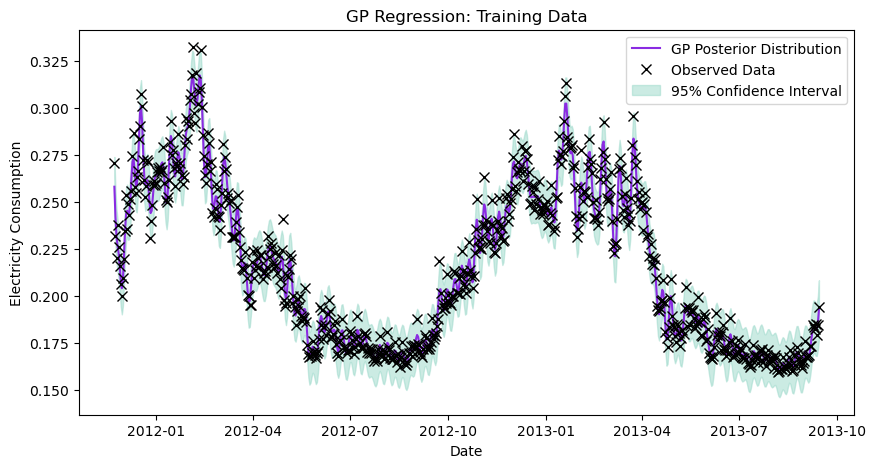

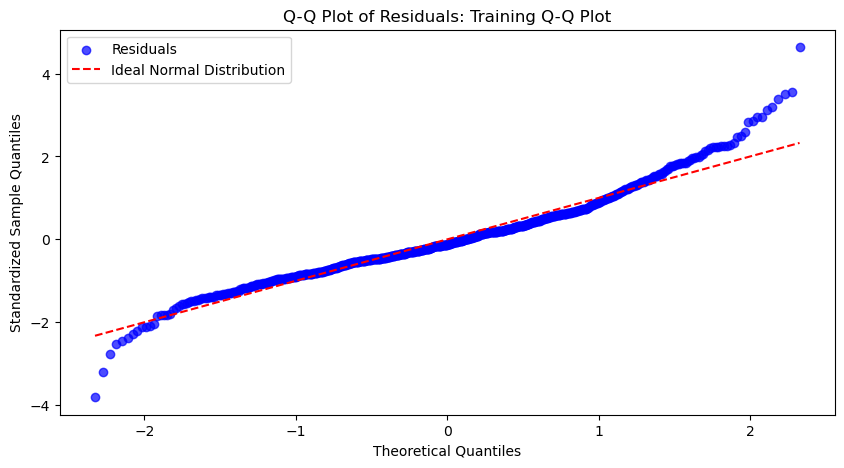

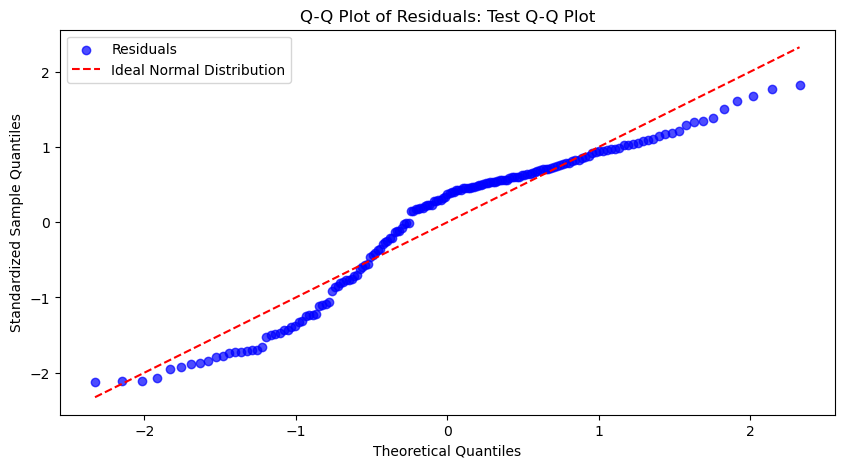


Testing Results:
Mean Squared Error (MSE): 0.0006
Mean Absolute Percentage Error (MAPE): 9.86%
Log Likelihood: -93.88097336599537

Test Calibration Metrics:
actual_coverage: 1.0
expected_coverage: 0.95
calibration_error: 0.050000000000000044
under_coverage: False
over_coverage: True


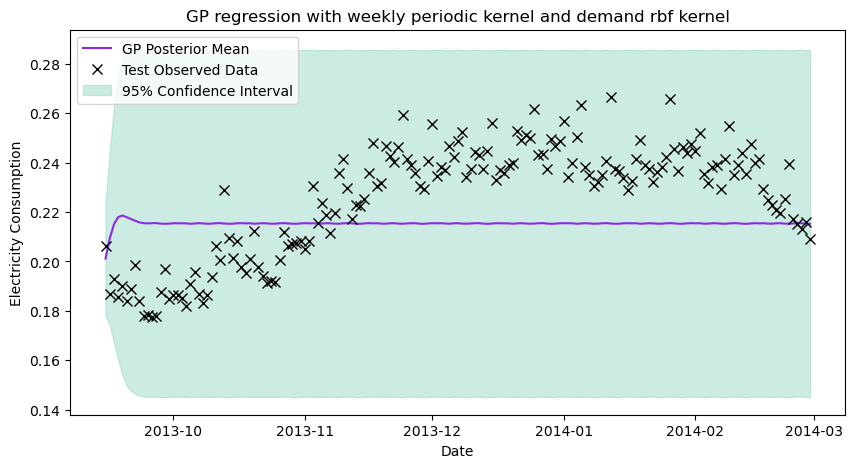

In [103]:
# Define kernel (e.g., RBF + Periodic)
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=20)
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=20, period=7
)
kernel = k_rbf + k_periodic

# Run GP regression
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    test_title="GP regression with weekly periodic kernel and demand rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s98  006   2.714676e+03   1.824474e+07 
    16s50  024   1.191789e+02   1.904372e+05 
    41s98  060   1.045664e+02   1.263871e+00 
    50s42  072   1.044988e+02   1.058467e-03 
    53s22  076   1.044988e+02   1.761005e-08 
Runtime:     53s22
Optimization status: Converged

Optimization restart 1/5, f = 104.4987973232308
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s37  002   9.408245e+02   8.943378e+04 
    08s21  012   9.401615e+02   1.694274e+03 
    12s54  019   8.836489e+02   7.211150e+09 
Runtime:     12s54
Optimization status: Converged

Optimization restart 2/5, f = 883.6489138505138
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s00  000   8.830626e+02   7.211150e+09 
    08s73  012   1.368534e+02   1.148427e+06 
    26s66  038   1.025159e+02   6.947535e+08 
    29s59  042   9.9177

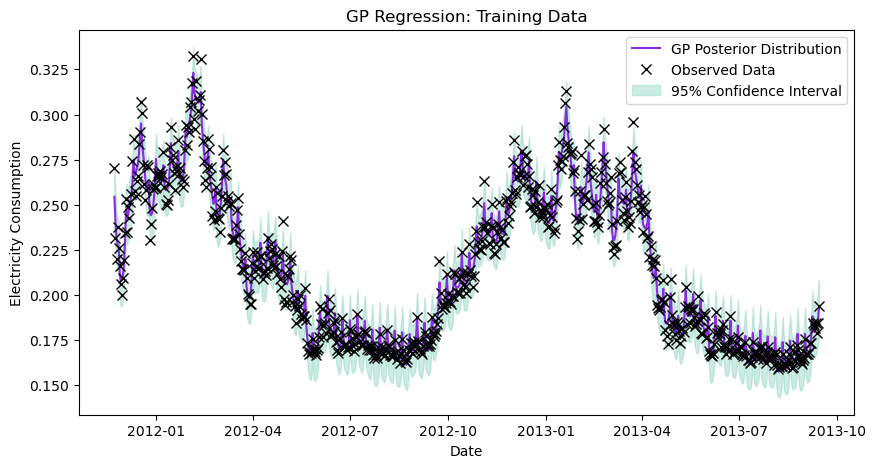

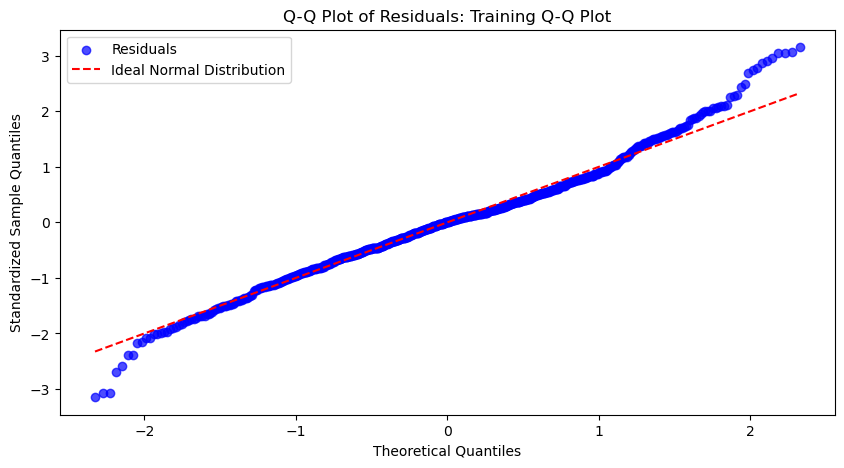

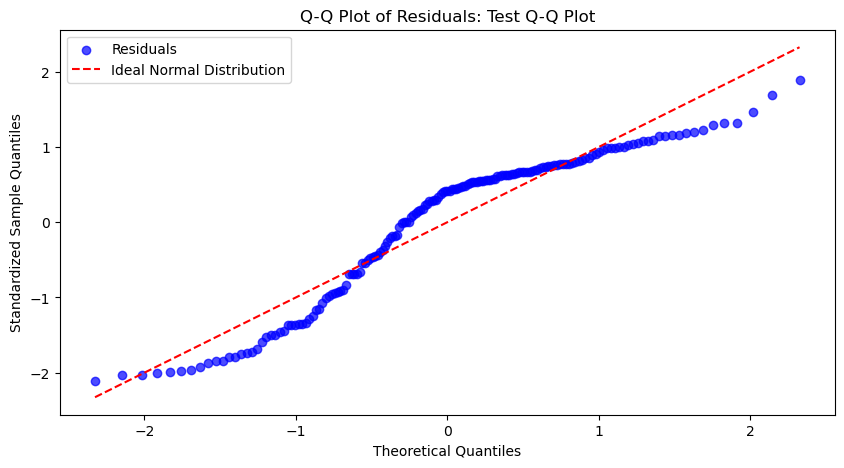


Testing Results:
Mean Squared Error (MSE): 0.0005
Mean Absolute Percentage Error (MAPE): 9.34%
Log Likelihood: 16.54457931180889

Test Calibration Metrics:
actual_coverage: 1.0
expected_coverage: 0.95
calibration_error: 0.050000000000000044
under_coverage: False
over_coverage: True


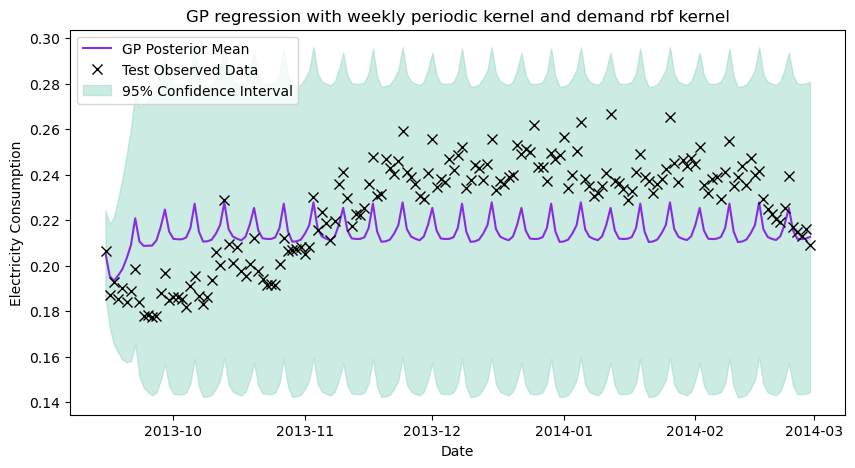

In [ ]:
# Demand RBF + Weekly Periodic
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10)
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=20, period=7
)
kernel = k_rbf + k_periodic

# Run GP regression
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    test_title="GP regression with weekly periodic kernel and demand rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s03  001   6.826438e+02   3.159863e+04 

 /Users/zhihaosu/anaconda3/envs/ts1018/lib/python3.12/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


    00s09  002   4.963134e+02   3.488966e+04 
    00s18  005   7.964786e+02   9.004314e+05 
    00s91  031   2.123791e+02   1.383075e-08 
Runtime:     00s91
Optimization status: Converged

Optimization restart 1/5, f = 212.37912865796716
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s06  002   2.166665e+02   8.804274e+03 
    00s45  015   1.947424e+02   2.138061e-07 
Runtime:     00s45
Optimization status: Converged

Optimization restart 2/5, f = 194.7424496725044
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s16  006   1.971833e+02   1.593322e+02 
    00s65  024   1.947424e+02   4.031531e-10 
Runtime:     00s65
Optimization status: Converged

Optimization restart 3/5, f = 194.74244967045098
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s08  002   4.320602e+02   4.013610e+04 
    00s47  017   1.947424e+02   1.181894e-09 
Runtime:     0

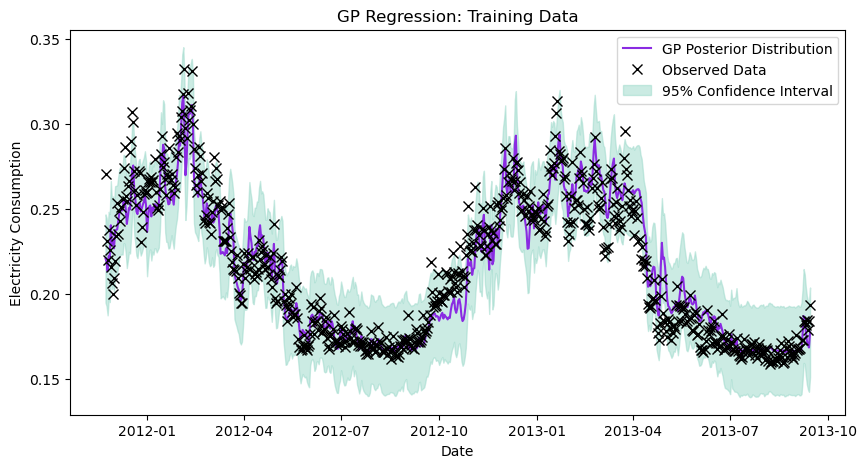

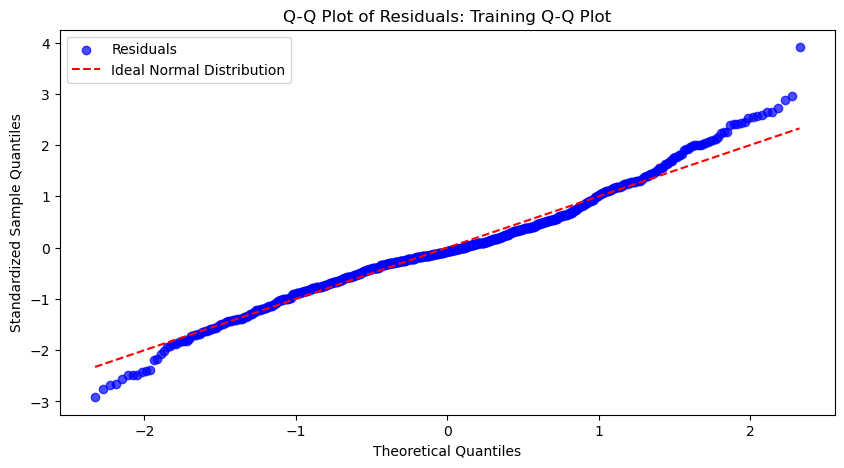

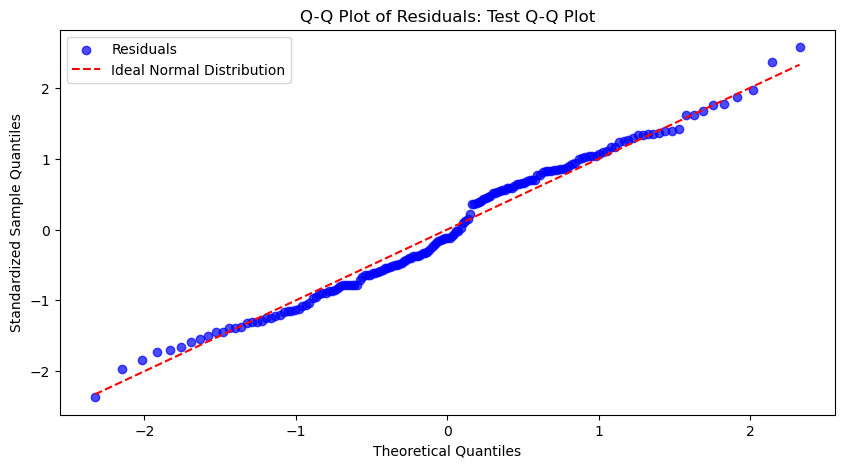


Testing Results:
Mean Squared Error (MSE): 0.0003
Mean Absolute Percentage Error (MAPE): 6.49%
Log Likelihood: -194.74244967045098

Test Calibration Metrics:
actual_coverage: 0.8802395209580839
expected_coverage: 0.95
calibration_error: 0.06976047904191607
under_coverage: True
over_coverage: False


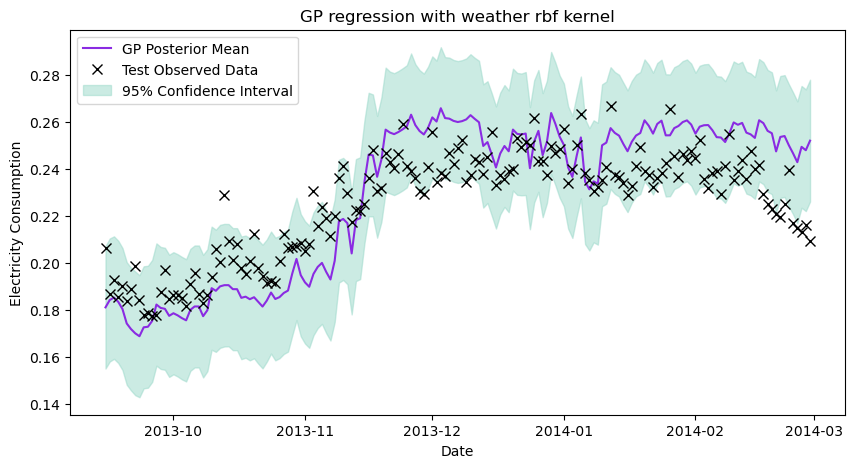

In [99]:
# Define kernel (e.g., RBF + Periodic + Weather RBF)
k_rbf_weather = GPy.kern.RBF(
    input_dim=2, variance=1, lengthscale=10, active_dims=[1, 2]
)
kernel = k_rbf_weather

# Run GP regression with weather data
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    weather_train_scaled,
    weather_test_scaled,
    test_title="GP regression with weather rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    04s05  006   2.175695e+03   1.270156e+07 
    08s10  012   2.693178e+01   9.696871e+04 
    20s49  030   1.070593e+01   2.264451e+05 
    27s54  040  -2.490777e+01   7.298516e+02 
    31s37  045  -3.850202e+01   4.616419e+03 
    32s61  047  -3.934049e+01   8.144358e+02 
    44s12  063  -4.492655e+01   1.385365e+02 
 01m23s07  119  -4.572640e+01   2.899761e-01 
 01m24s46  121  -4.572713e+01   7.150044e-02 
 01m27s78  126  -4.572762e+01   4.418592e-05 
Runtime:  01m27s78
Optimization status: Converged

Optimization restart 1/1, f = -45.72761663335143
Training Results:
Mean Squared Error (MSE): 0.0000
Mean Absolute Percentage Error (MAPE): 2.42%
Log Likelihood: 45.72761663335143
AIC: -75.4552

Training Calibration Metrics:
actual_coverage: 0.9667673716012085
expected_coverage: 0.95
calibration_error: 0.01676737160120856
under_coverage: False
over_coverage: True


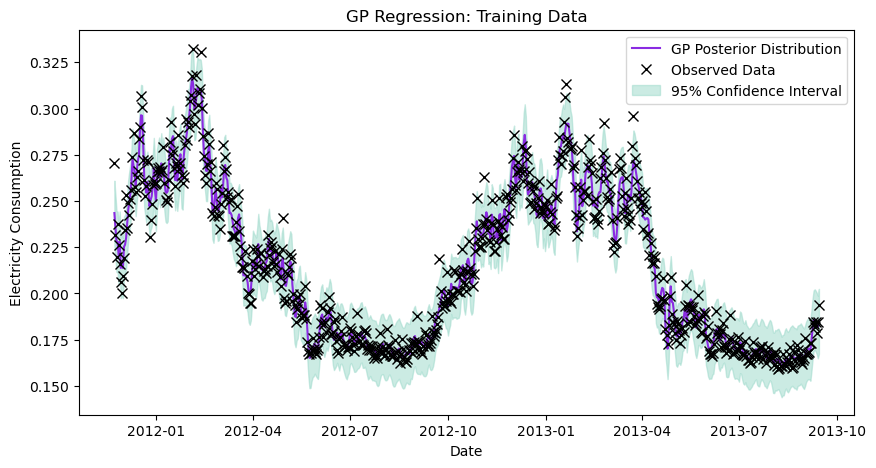

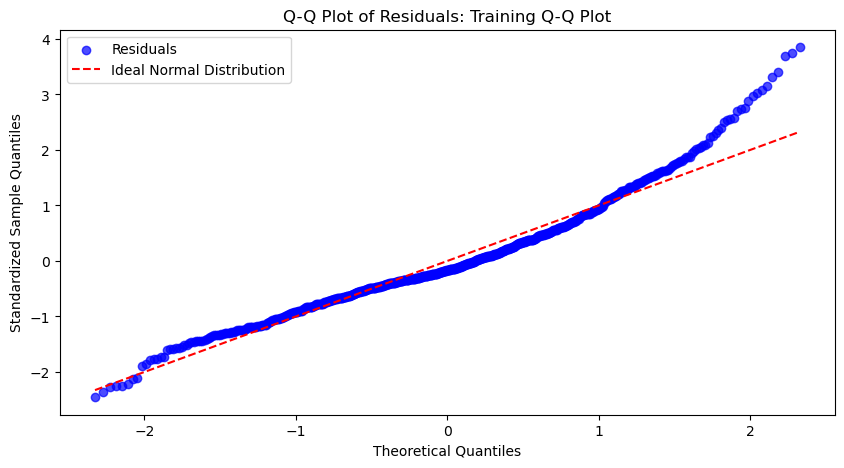

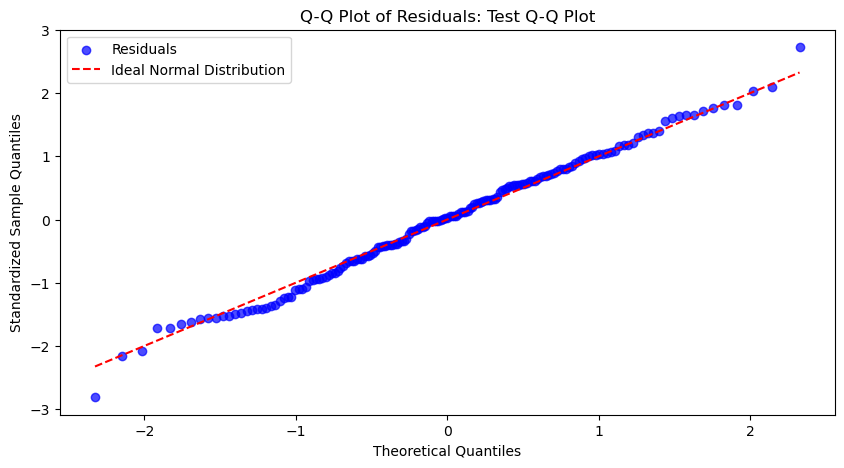


Testing Results:
Mean Squared Error (MSE): 0.0002
Mean Absolute Percentage Error (MAPE): 4.70%
Log Likelihood: 45.72761663335143

Test Calibration Metrics:
actual_coverage: 0.9760479041916168
expected_coverage: 0.95
calibration_error: 0.026047904191616844
under_coverage: False
over_coverage: True


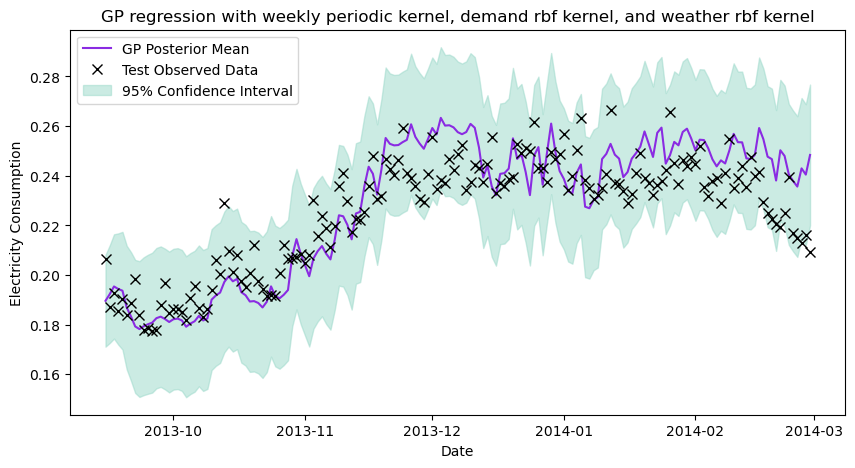

In [109]:
# Define kernel (e.g., RBF + Periodic + Weather RBF)
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10, active_dims=[0])
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=10, period=7, active_dims=[0]
)
k_rbf_weather = GPy.kern.RBF(
    input_dim=2, variance=1, lengthscale=10, active_dims=[1, 2]
)
kernel = k_rbf + k_periodic + k_rbf_weather

# Run GP regression with weather data
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    weather_train_scaled,
    weather_test_scaled,
    test_title="GP regression with weekly periodic kernel, demand rbf kernel, and weather rbf kernel",
    num_restarts=1
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s43  002   5.064993e+02   4.679969e+04 
    08s68  012   2.693178e+01   9.696871e+04 
    18s40  026   1.702654e+01   3.330507e+05 
    23s89  034  -4.579893e+00   3.100235e+03 
    33s72  048  -3.930348e+01   2.585504e+03 
    44s96  064  -4.498084e+01   5.288074e+01 
 01m23s06  118  -4.572636e+01   1.820093e-01 
 01m28s71  126  -4.572762e+01   4.418592e-05 
Runtime:  01m28s71
Optimization status: Converged

Optimization restart 1/5, f = -45.72761663335143
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s00  000   8.850452e+02   4.418592e-05 
    05s44  008   8.364621e+02   2.152547e+04 
    10s98  016   4.821994e+01   3.122256e+05 
    13s78  020   3.903739e+01   2.287862e+07 
    23s39  033  -5.966107e+01   8.789593e+05 
    42s63  060  -6.666551e+01   2.339394e+04 
 01m06s59  094  -6.751327e+01   1.387057e+04 
 02m20s74  200  -7.296750e+0

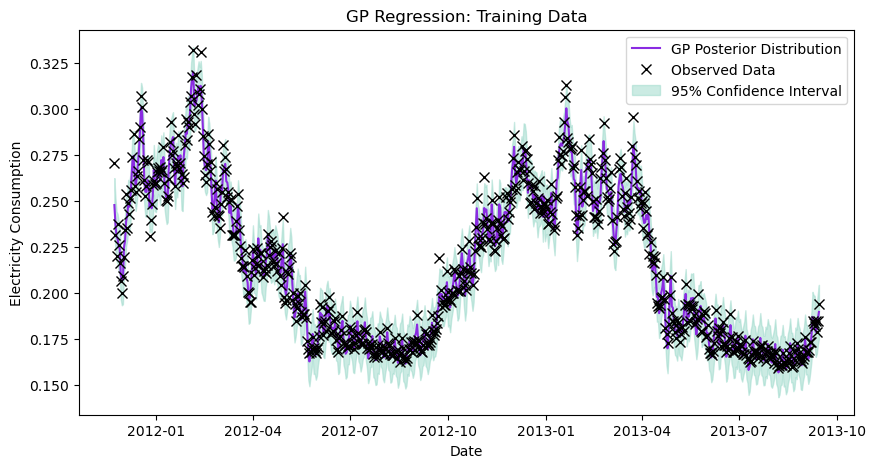

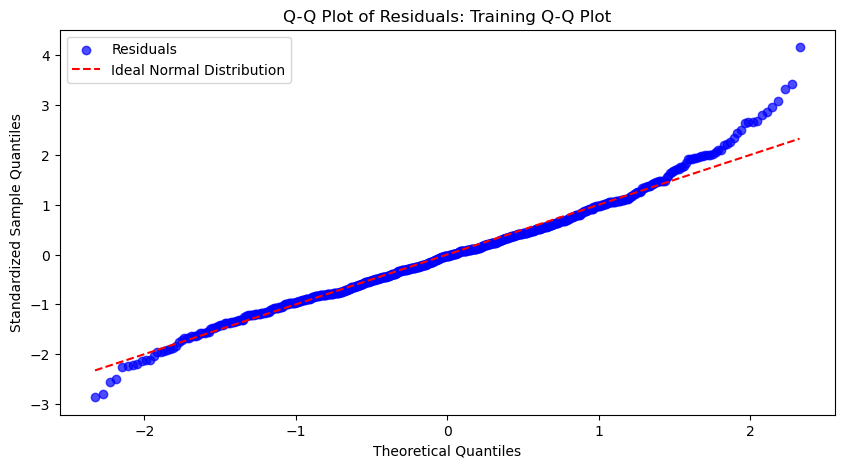

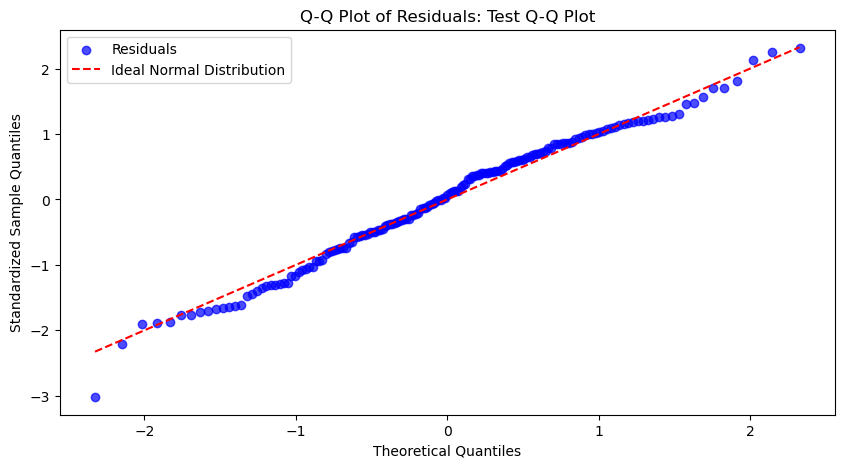


Testing Results:
Mean Squared Error (MSE): 0.0001
Mean Absolute Percentage Error (MAPE): 4.27%
Log Likelihood: 111.14446158737223

Test Calibration Metrics:
actual_coverage: 0.9880239520958084
expected_coverage: 0.95
calibration_error: 0.038023952095808444
under_coverage: False
over_coverage: True


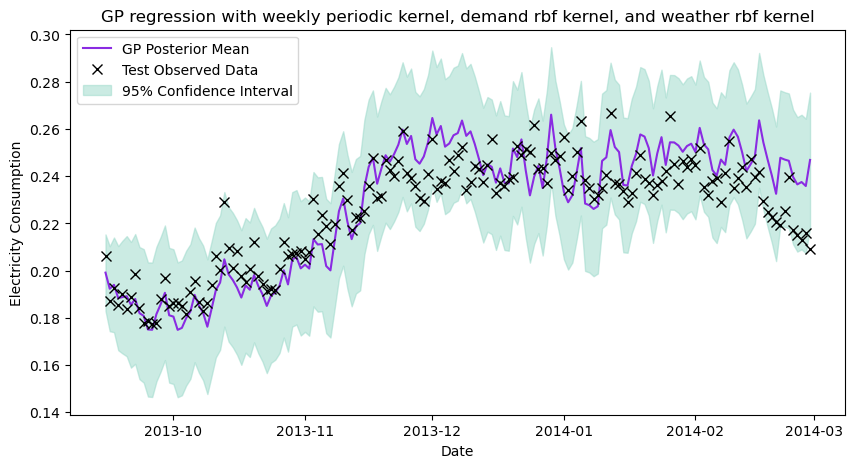

In [ ]:
# Define kernel (e.g., RBF + Periodic + Weather RBF)
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10, active_dims=[0])
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=10, period=7, active_dims=[0]
)
k_rbf_weather = GPy.kern.RBF(
    input_dim=2, variance=1, lengthscale=10, active_dims=[1, 2]
)
kernel = k_rbf + k_periodic + k_rbf_weather

# Run GP regression with weather data
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    weather_train_scaled,
    weather_test_scaled,
    test_title="GP regression with weekly periodic kernel, demand rbf kernel, and weather rbf kernel",
)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    04s09  005   3.327268e+01   3.381899e+04 
    09s42  013   3.137112e+01   8.758672e+04 
    28s08  041  -3.581947e+01   1.086553e+04 
    37s54  055  -3.770776e+01   3.764945e+04 
    44s45  065  -4.513174e+01   2.804385e-02 
    59s72  087  -4.519176e+01   1.390199e+02 
 01m09s98  101  -4.569844e+01   8.922447e-01 
 01m14s10  107  -4.572497e+01   3.517342e+00 
 01m18s03  113  -4.572647e+01   2.643644e-01 
 01m19s49  115  -4.572662e+01   2.073291e-02 
 01m22s15  119  -4.572665e+01   4.706521e-07 
Runtime:  01m22s15
Optimization status: Converged

Optimization restart 1/5, f = -45.72664908161505
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    05s51  008   2.098282e+02   5.516699e+08 
    07s39  010   2.098282e+02   5.438145e+07 
Runtime:     07s39
Optimization status: Converged

Optimization restart 2/5, f = 209.82820371187648
Running L-BFGS-B (Sc

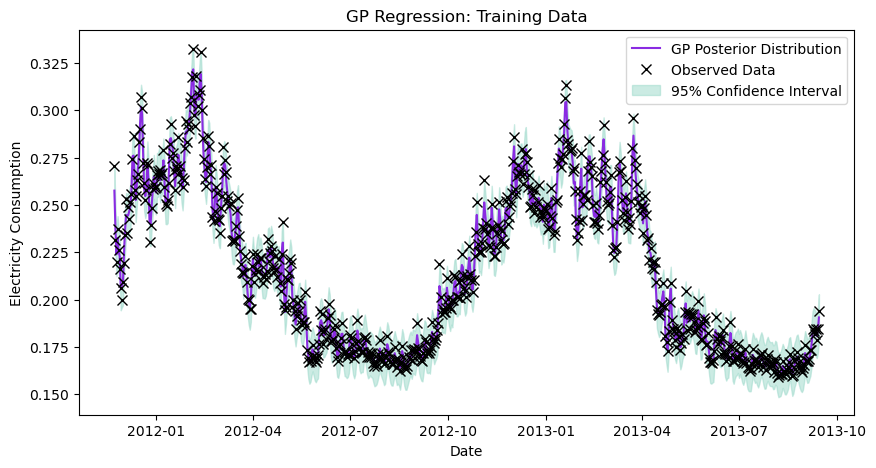

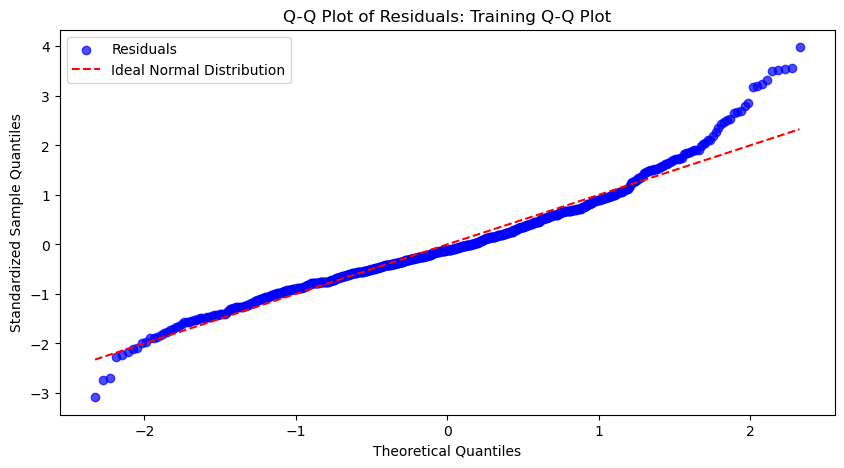

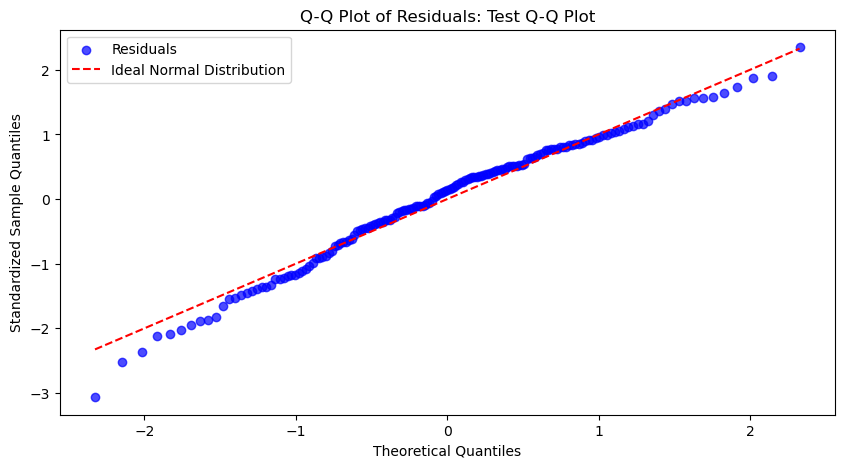


Testing Results:
Mean Squared Error (MSE): 0.0002
Mean Absolute Percentage Error (MAPE): 5.25%
Log Likelihood: 117.55778718046747

Test Calibration Metrics:
actual_coverage: 0.874251497005988
expected_coverage: 0.95
calibration_error: 0.07574850299401192
under_coverage: True
over_coverage: False


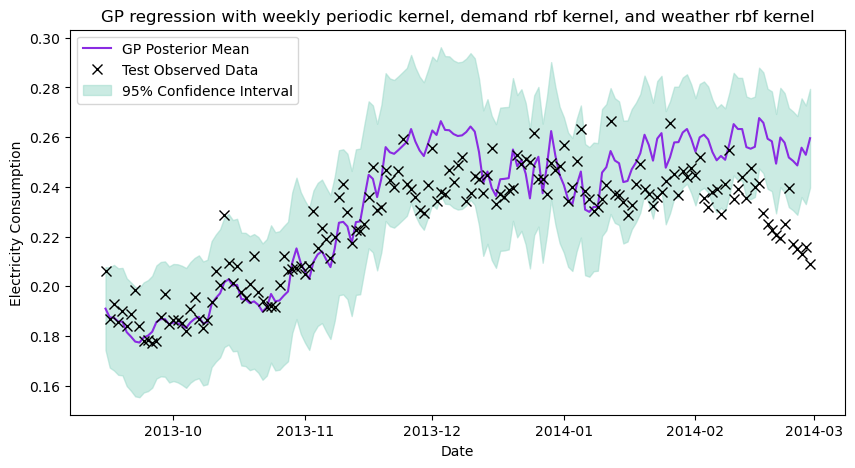

In [ ]:
# Define kernel (e.g., RBF + Periodic + Weather RBF)
k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10, active_dims=[0])
k_periodic = GPy.kern.PeriodicExponential(
    input_dim=1, variance=1, lengthscale=20, period=7, active_dims=[0]
)
k_rbf_weather = GPy.kern.RBF(
    input_dim=2, variance=1, lengthscale=10, active_dims=[1, 2]
)
kernel = k_rbf + k_periodic + k_rbf_weather

# Run GP regression with weather data
results = run_gp_with_kernel(
    train_series,
    test_series,
    kernel,
    weather_train_scaled,
    weather_test_scaled,
    test_title="GP regression with weekly periodic kernel, demand rbf kernel, and weather rbf kernel",
)